epoch : 0, loss : 2.7161762714385986
epoch : 10, loss : 0.09263835847377777
epoch : 20, loss : 0.048664942383766174
epoch : 30, loss : 0.039323098957538605
epoch : 40, loss : 0.035940513014793396
epoch : 50, loss : 0.034004583954811096
epoch : 60, loss : 0.03202627971768379
epoch : 70, loss : 0.030840320512652397
epoch : 80, loss : 0.03040592558681965
epoch : 90, loss : 0.028725232928991318
0.9775730805962976
0.7629768889157473
0.41286807209764187
0.03193934428838851
0.20665208762213624
0.355612928224798


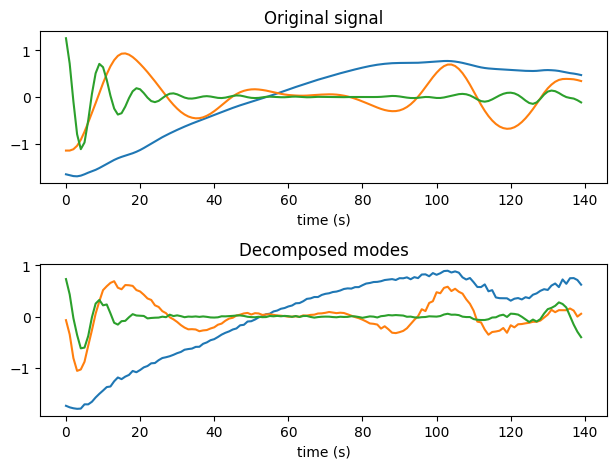

In [1]:
import torch
from torch.utils.data import TensorDataset
import random
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd
import numpy as np
from scipy.io import arff, loadmat
from sklearn.model_selection import train_test_split
from utils.util import seed_everything_th, weight_init_xavier_uniform
from models.model import VMDNet
import subprocess

EPOCH = 100
seed = 123456
seed_everything_th(seed)

subprocess.run("julia ./utils/preprocessing.jl")

input_tr = arff.loadarff("./dataset/ECG5000_TRAIN.arff")
input_tr = pd.DataFrame(input_tr[0], dtype=np.float32).values[:,:140].reshape(500, 1, 140)

input_ts = arff.loadarff("./dataset/ECG5000_TEST.arff")
input_ts = pd.DataFrame(input_ts[0], dtype=np.float32).values[:,:140].reshape(4500, 1, 140)

target_tr = loadmat("./dataset/processed_train.mat")["data"].reshape(500, 3, 140)
target_ts = loadmat("./dataset/processed_test.mat")["data"].reshape(4500, 3, 140)

train_loader = torch.utils.data.DataLoader(dataset = TensorDataset(torch.FloatTensor(input_tr), torch.FloatTensor(target_tr)), batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = TensorDataset(torch.FloatTensor(input_ts), torch.FloatTensor(target_ts)), batch_size = 32, shuffle = True)

model = VMDNet()
model.apply(weight_init_xavier_uniform)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, eps=1e-8, betas=(0.9, 0.999))
criterion = torch.nn.MSELoss()

for i in range(EPOCH):
    avg_cost = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)

        cost = criterion(output, target)
        cost.backward()
        optimizer.step()
        avg_cost += cost / len(train_loader)
        
    if i % 10 == 0:
        print("epoch : {0}, loss : {1}".format(i, avg_cost.item()))

imf1_s = []
imf2_s = []
imf3_s = []

imf_all = []

model.eval()
with torch.no_grad(): 
    correct = 0
    total = 0

    for i, (datax, targetx) in enumerate(test_loader):
        out = model(datax)

        imf_all.append(out.cpu().numpy())
        a = targetx.numpy()[0].reshape(140, 3)
        b = out.numpy()[0].reshape(140, 3)

        imf1 = np.corrcoef(a[:, 0], b[:, 0])[0, 1]
        imf2 = np.corrcoef(a[:, 1], b[:, 1])[0, 1]
        imf3 = np.corrcoef(a[:, 2], b[:, 2])[0, 1]

        imf1_s.append(imf1)
        imf2_s.append(imf2)
        imf3_s.append(imf3)

print(np.mean(imf1_s))
print(np.mean(imf2_s))
print(np.mean(imf3_s))
print(np.std(imf1_s))
print(np.std(imf2_s))
print(np.std(imf3_s))

plt.figure()
plt.subplot(2,1,1)
plt.plot(a)
plt.title('Original signal')
plt.xlabel('time (s)')
plt.subplot(2,1,2)
plt.plot(b)
plt.title('Decomposed modes')
plt.xlabel('time (s)')
plt.tight_layout()
plt.show()